In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import pickle as pkl
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import Image
import pandas as pd
from tqdm import tqdm

from causallearn.search.ConstraintBased.FCI import fci
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils
from causallearn.graph.GraphClass import CausalGraph
from causallearn.utils.DAG2CPDAG import dag2cpdag
from causallearn.graph.Edge import Edge
from causallearn.graph.Endpoint import Endpoint
from causallearn.graph.SHD import SHD

import io
import matplotlib.image as mpimg

import seaborn as sns

In [35]:
#galtypes = ['ell','len','spr','full']
galtypes = ['ell','len','spr']
typename = {'ell':'E','len':'S0','spr':'S','full':'Total'}
# galtypes = ['ell','ell_200000']
# typename = {'ell_200000':'E_200000','ell':'E_100000'}
labels_list = [r'$\text{M}_\bullet$',r'$\sigma_0$', r'$\text{R}_e$', r'$\Sigma_e$',
       r'$\text{M}^*$', r'$\text{sSFR}$', r'$\text{W}_2-\text{W}_3$']
labels_list_fci = ['M_bh','sigma_0', 'R_e', 'Sigma_e','M*', 'sSFR', 'W_2-W_3']

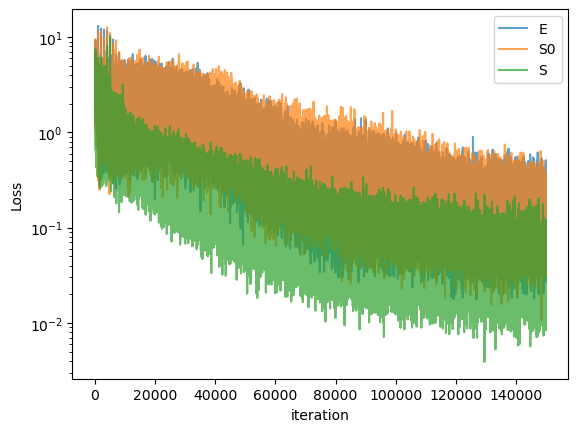

In [36]:
for galtype in galtypes:
    folder = 'output_'+galtype+'/'
    loss = np.load(folder+'loss_array.npy')
    plt.plot(loss,label=typename[galtype],alpha=0.7)
    plt.xlabel('iteration')
    plt.ylabel('Loss')
    plt.yscale('log')

plt.legend()

In [37]:
def find_unique_dag(posterior):
    unique_samples, counts = np.unique(posterior, axis=0, return_counts=True)
    sorted_indices = np.argsort(-counts)
    unique_samples = unique_samples[sorted_indices]
    counts = counts[sorted_indices]
    print('unique DAG rate: ',unique_samples.shape[0]/posterior.shape[0]*100,'%')

    return unique_samples, counts

## from dag-gflownet
def expected_shd(posterior, ground_truth):
    """Compute the Expected Structural Hamming Distance.

    This function computes the Expected SHD between a posterior approximation
    given as a collection of samples from the posterior, and the ground-truth
    graph used in the original data generation process.

    Parameters
    ----------
    posterior : np.ndarray instance
        Posterior approximation. The array must have size `(B, N, N)`, where `B`
        is the number of sample graphs from the posterior approximation, and `N`
        is the number of variables in the graphs.

    ground_truth : np.ndarray instance
        Adjacency matrix of the ground-truth graph. The array must have size
        `(N, N)`, where `N` is the number of variables in the graph.

    Returns
    -------
    e_shd : float
        The Expected SHD.
    """
    # Compute the pairwise differences
    diff = np.abs(posterior - np.expand_dims(ground_truth, axis=0))
    diff = diff + diff.transpose((0, 2, 1))

    # Ignore double edges
    diff = np.minimum(diff, 1)
    shds = np.sum(diff, axis=(1, 2)) / 2

    #return np.mean(shds)
    return shds


def plot_top_dags(unique_samples, counts, num=10, render_latex=False, save: str |None = None):
    labels_list = [r'$\text{M}_\bullet$',r'$\sigma_0$', r'$\text{R}_e$', r'$\Sigma_e$',
       r'$\text{M}^*$', r'$\text{sSFR}$', r'$\text{W}_2-\text{W}_3$']
    samplesize = counts.sum()
    # Render LaTeX to an image
    def render_latex_to_file(str, filepath):
        fig = plt.figure()
        fig = plt.figure(figsize=(0.01, 0.01))
        fig.text(0.5, 0.5, str, fontsize='xx-large', ha='center', va='center')
        plt.axis('off')
        plt.savefig(filepath, bbox_inches='tight')
        plt.close(fig)
    
    if render_latex:
        for i,string in enumerate(labels_list):
            render_latex_to_file(string,'label'+str(i)+'.png')


    for i, sample in enumerate(unique_samples[:num]):
        graph = nx.from_numpy_array(sample, create_using=nx.DiGraph)

        
        # Apply labels to the graph
        for j,node in enumerate(graph.nodes()):
            graph.nodes[node]['image'] = 'label'+str(j)+'.png'
            graph.nodes[node]['label'] = ''

        
        gviz = nx.nx_agraph.to_agraph(graph)

        gviz.graph_attr['label'] = str(counts[i])+'/'+str(samplesize)+' ('+format(counts[i]/samplesize*100,'.3g')+'%)'
        gviz.graph_attr['labelloc'] = 't'  # Top of the graph
        gviz.graph_attr['labeljust'] = 'l'  # Right-justified
        gviz.graph_attr['fontsize'] = 15
        gviz.graph_attr['fontname'] = 'Calibri'
        gviz.graph_attr['dpi'] = 100


        # Render the graph to a PNG image and display it inline
        if save is None:
            output_path = 'graph.png'
        else:
            output_path = save+'_top'+str(i+1)+'.png'
        gviz.draw(output_path, prog='dot', format='png')  # Use 'dot' or another Graphviz layout engine

        

        #print(counts[i],'/',samplesize,'(',counts[i]/samplesize*100,'%)')
        # Display the image
        display(Image(output_path))


def parent_child_matrix(posterior, typename: str |None = None):
    # edge marginals
    labels_list = [r'$\text{M}_\bullet$',r'$\sigma_0$', r'$\text{R}_e$', r'$\Sigma_e$',
       r'$\text{M}^*$', r'$\text{sSFR}$', r'$\text{W}_2-\text{W}_3$']
    confusion = posterior.mean(axis=0)
    #confusion = posterior.std(axis=0)
    #sns.heatmap(confusion, cmap='gray', annot=confusion,fmt='.3f')
    sns.heatmap(confusion, cmap='gray', annot=confusion)
    if typename is not None:
        plt.title(typename)
    plt.xlabel('Child')
    plt.ylabel('Parent')
    plt.xticks(np.arange(len(labels_list))+0.5, labels_list, rotation=60)
    plt.yticks(np.arange(len(labels_list))+0.5, labels_list, rotation=0)
    plt.show()

    # path marginals
    transitive_closure = np.zeros(posterior.shape)
    for i in range(posterior.shape[0]):
        # get transitive closure of the graph
        G = nx.from_numpy_array(posterior[i], create_using=nx.DiGraph)
        # Compute the transitive closure of the graph
        TC = nx.transitive_closure(G)

        # Convert the transitive closure graph back to a numpy array
        tc_adj_matrix = nx.to_numpy_array(TC, dtype=int)

        transitive_closure[i] = tc_adj_matrix
    
    confusion = transitive_closure.mean(axis=0)
    sns.heatmap(confusion, cmap='gray', annot=confusion)
    if typename is not None:
        plt.title(typename)
    plt.xlabel('Descendant')
    plt.ylabel('Ancestor')
    plt.xticks(np.arange(len(labels_list))+0.5, labels_list, rotation=60)
    plt.yticks(np.arange(len(labels_list))+0.5, labels_list, rotation=0)
    plt.show()

unique DAG rate:  53.681 %
unique DAG rate:  51.722 %
unique DAG rate:  74.622 %


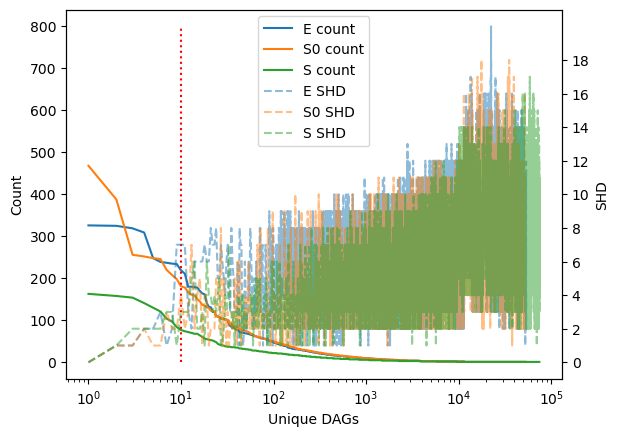

In [38]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

posterior={}
unique_samples={}
counts={}
shds={}
for galtype in galtypes:
    folder = 'output_'+galtype+'/'
    posterior[galtype] = np.load(folder+'posterior.npy')
    unique_samples[galtype], counts[galtype] = find_unique_dag(posterior[galtype])

    shds[galtype]=expected_shd(unique_samples[galtype], unique_samples[galtype][0])

    # plot count of unique samples on using the left y axis, and the shd on the right y axis

    ax1.plot(np.arange(len(counts[galtype]))+1, counts[galtype],label=typename[galtype]+' count')
    ax2.plot(np.arange(len(counts[galtype]))+1, shds[galtype], alpha=0.5,ls='--',label=typename[galtype]+' SHD')


ax1.set_xlabel('Unique DAGs')
ax1.set_ylabel('Count')
ax1.set_xscale('log')
ax2.set_ylabel('SHD')
ax2.set_yticks(np.arange(0, 20, 2))
ax1.vlines(10,0,800,linestyles='dotted',colors='r')

# Combine the legends of ax1 and ax2
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2,loc='upper center')




E


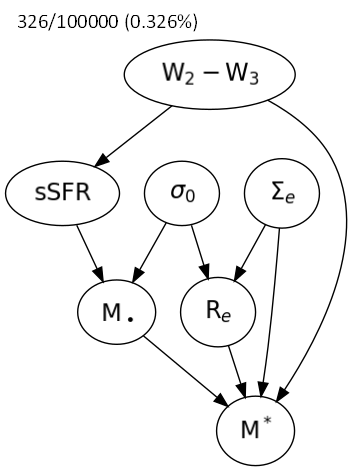

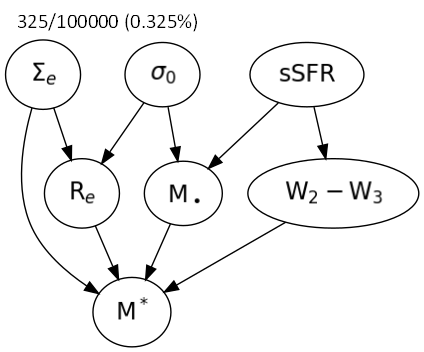

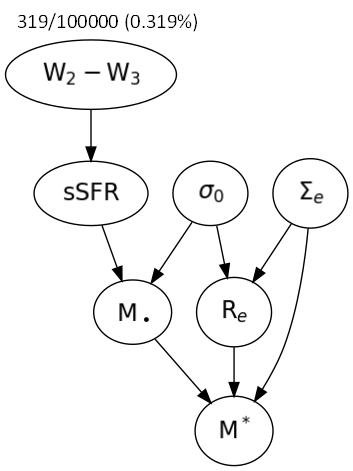

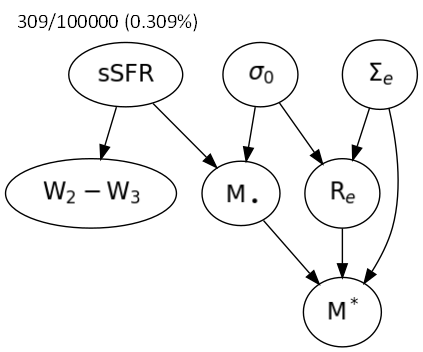

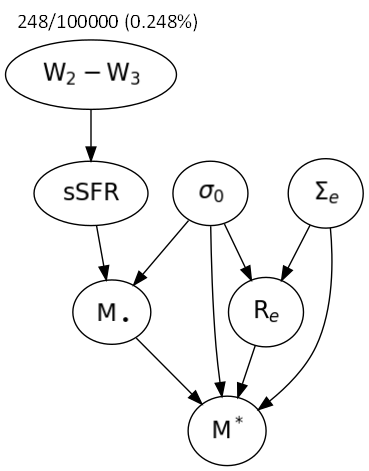

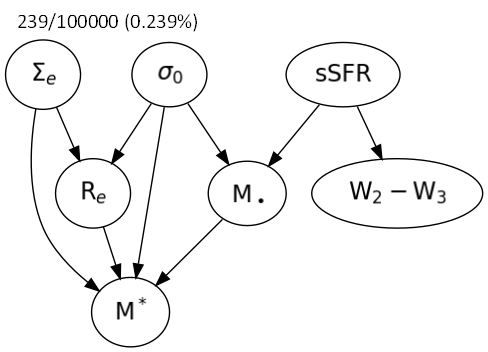

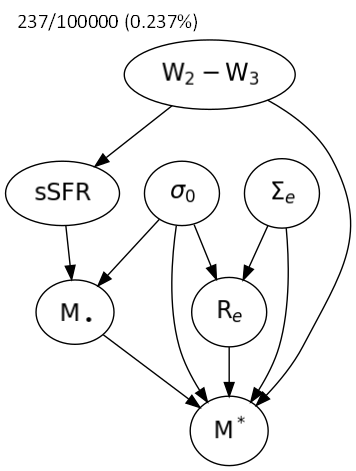

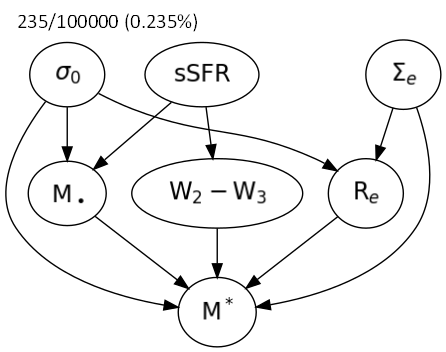

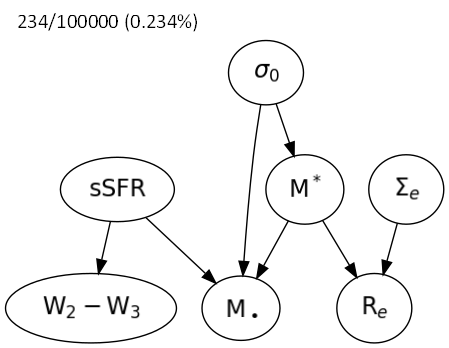

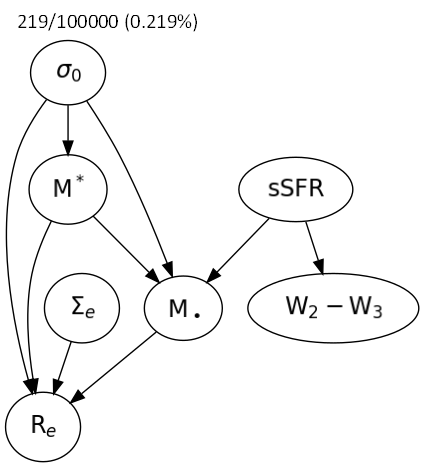

S0


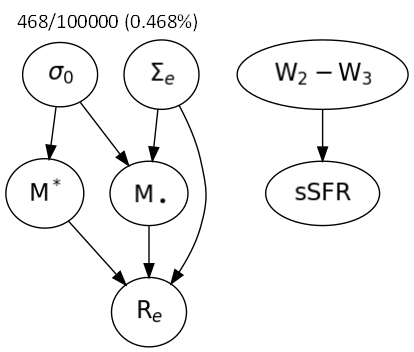

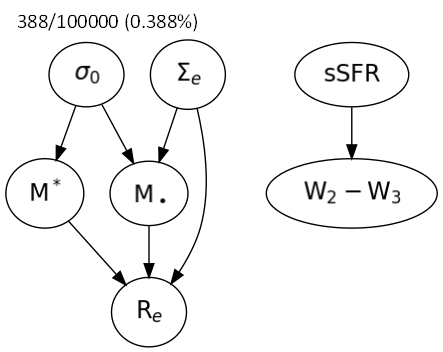

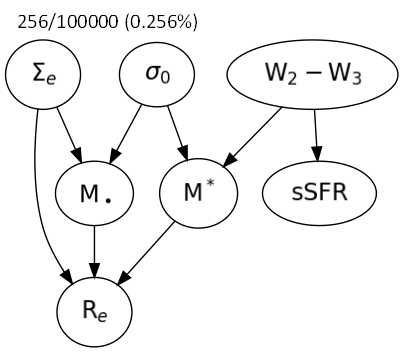

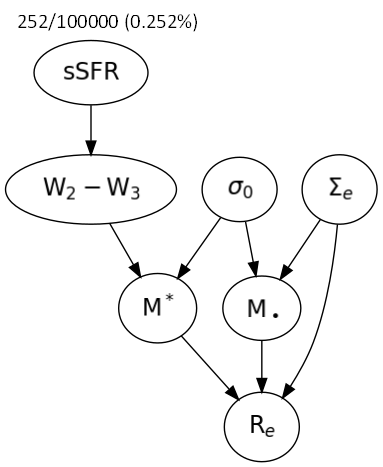

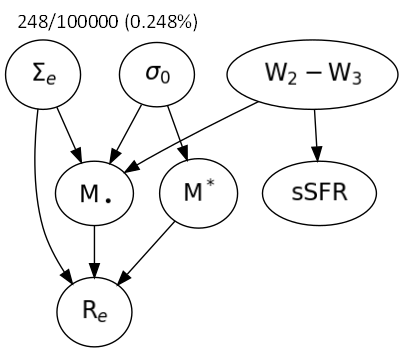

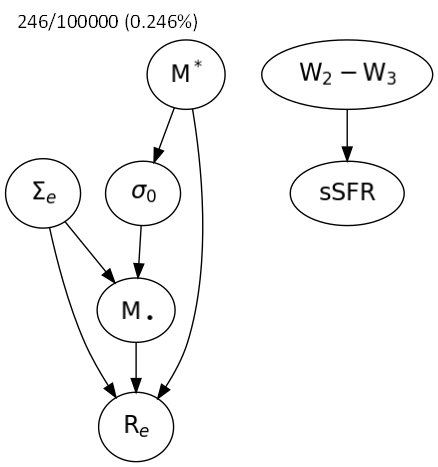

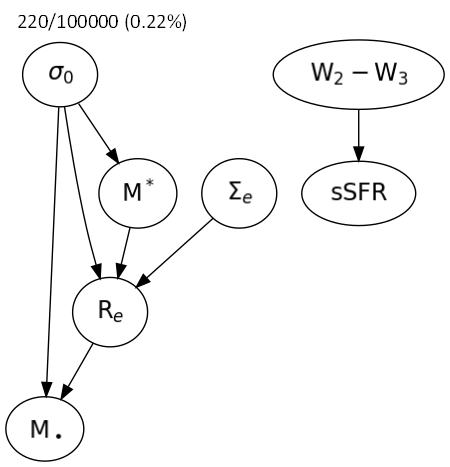

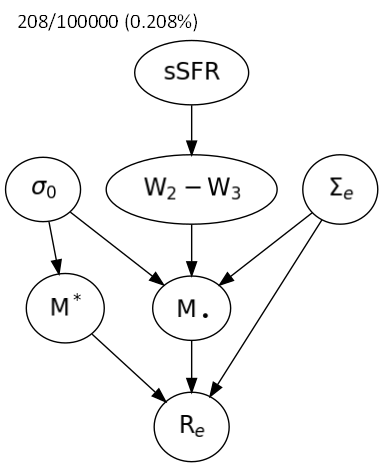

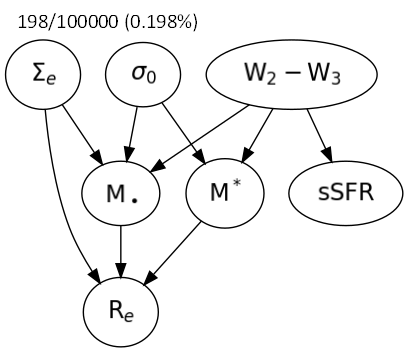

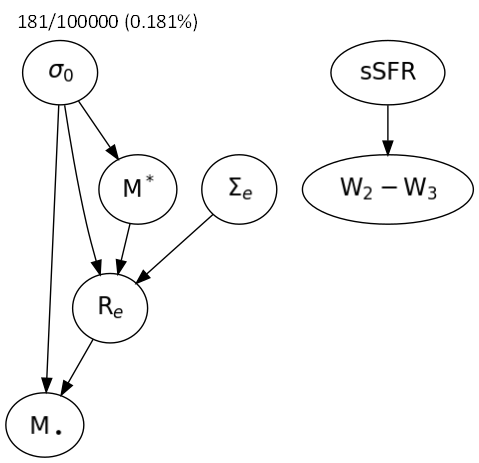

S


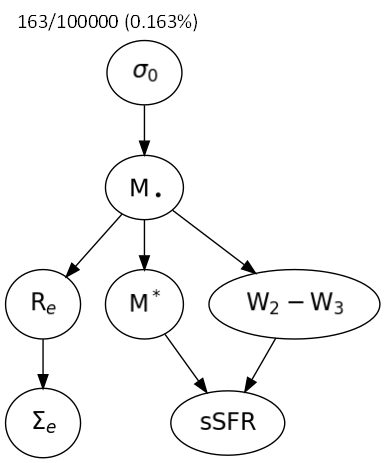

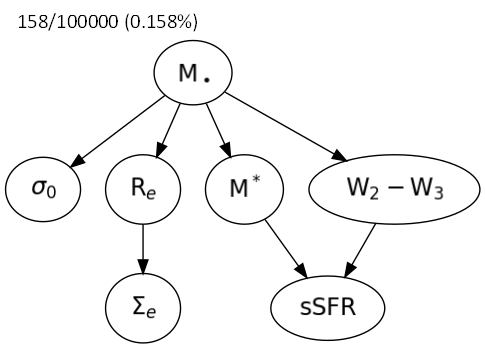

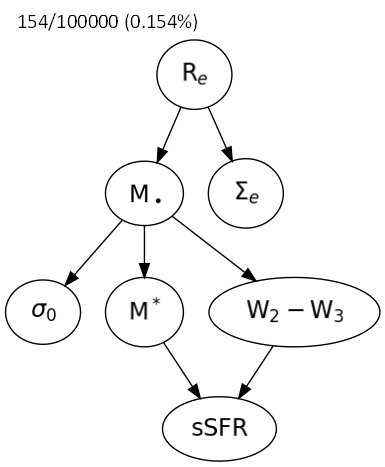

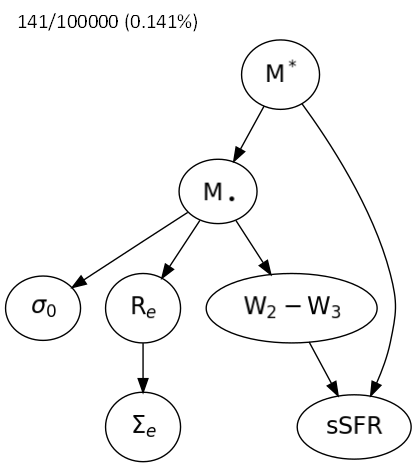

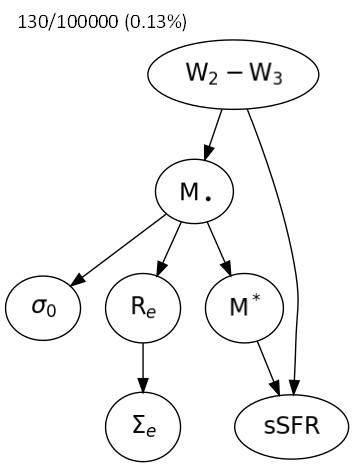

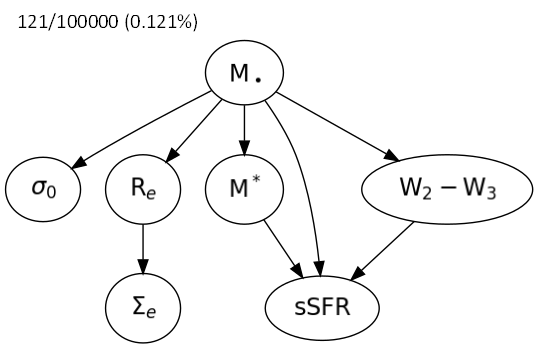

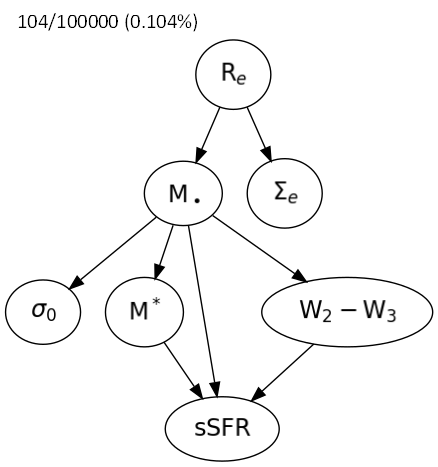

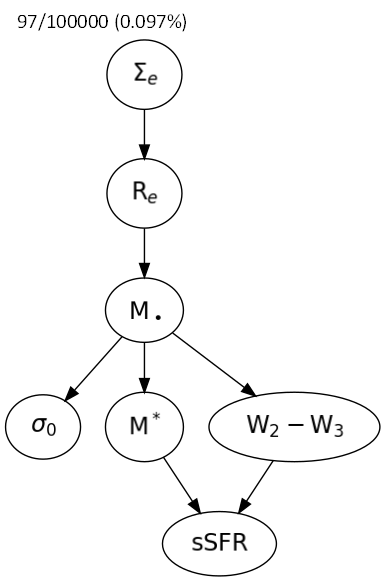

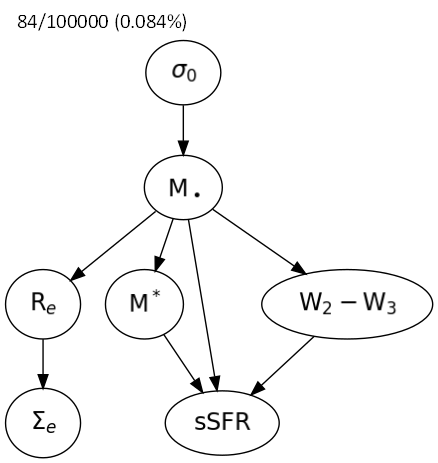

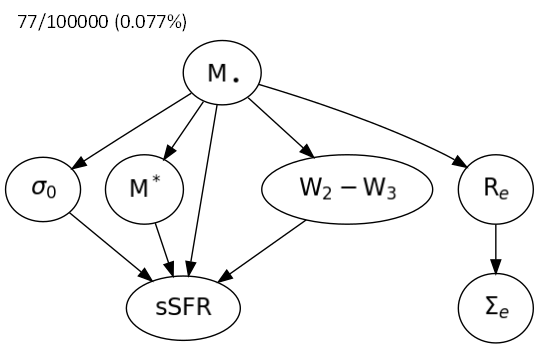

In [39]:
for galtype in galtypes:
    print(typename[galtype])
    print('===================================================')
    plot_top_dags(unique_samples[galtype], counts[galtype], num=10,save=galtype)
    print('===================================================')

E


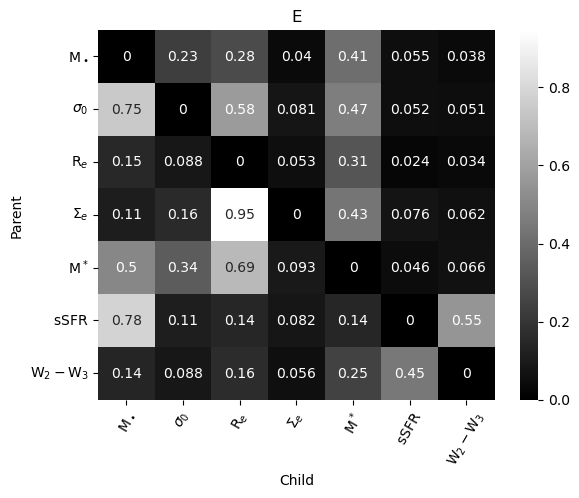

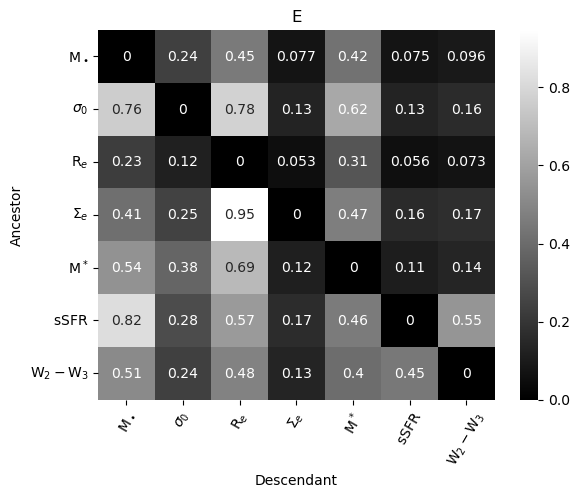

S0


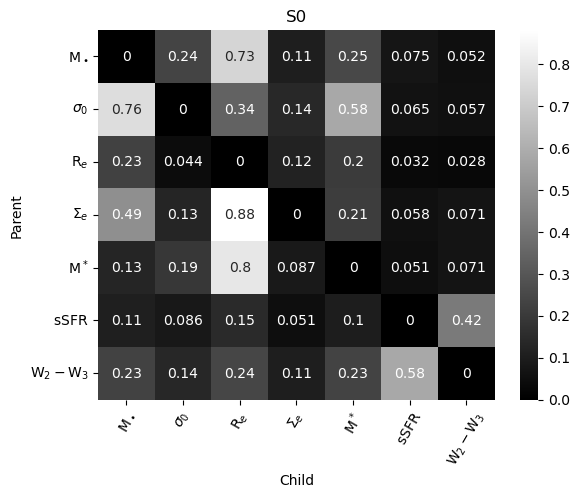

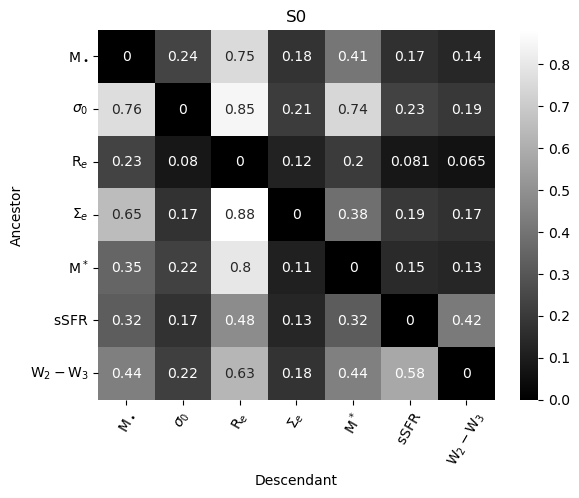

S


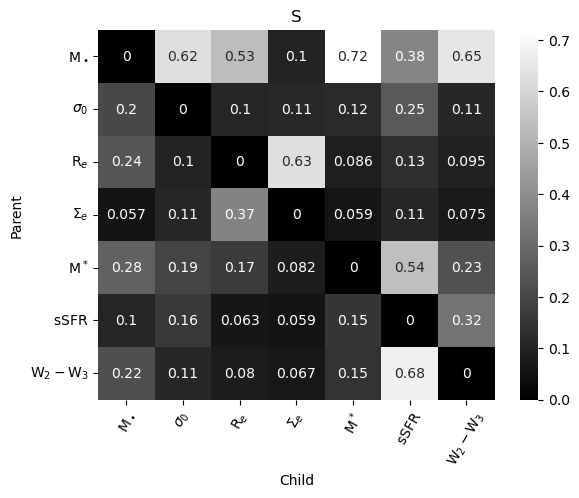

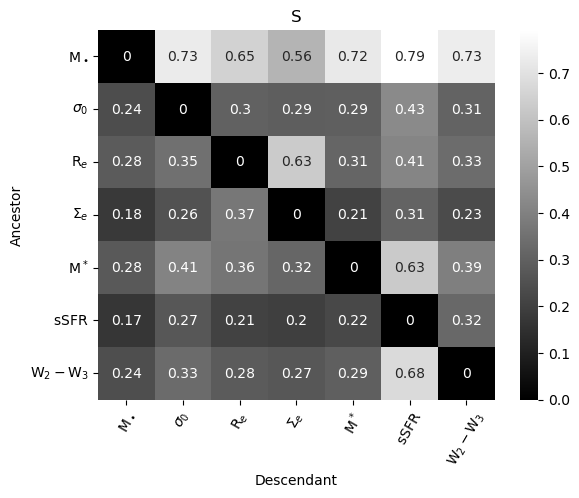

In [40]:
for galtype in galtypes:
    print(typename[galtype])
    print('===================================================')
    parent_child_matrix(posterior[galtype],typename=typename[galtype])
    print('===================================================')

In [13]:
   
def plot_fci(df,alpha=0.15,name='E'):
    labels_list_fci = ['M_bh','sigma_0', 'R_e', 'Sigma_e','M*', 'sSFR', 'W_2-W_3']
    g, edges = fci(np.array(df), "fisherz", alpha=alpha,verbose=False)
    pyd=GraphUtils.to_pydot(g,labels=labels_list_fci)
    #pyd=GraphUtils.to_pydot(g)

    # # Apply labels to the graph
    # for j,node in enumerate(pyd.get_nodes()):
    #     node_name=node.get_name()
    #     pyd.get_node(node_name)[0].set_image('label'+str(j//2)+'.png')
    #     pyd.get_node(node_name)[0].set_label = ''

    pyd.set_label(name+', FCI, alpha='+str(alpha))
    pyd.set_labelloc('t')
    pyd.set_fontsize(15)
    pyd.set_fontname('Calibri')
    pyd.set_dpi(600)

    tmp_png = pyd.create_png(f="png")
    fp = io.BytesIO(tmp_png)
    img = mpimg.imread(fp, format='png')
    plt.axis('off')
    plt.imshow(img)
    plt.show()

def plot_pc(df,alpha=0.15,name='E'):
    labels_list_fci = ['M_bh','sigma_0', 'R_e', 'Sigma_e','M*', 'sSFR', 'W_2-W_3']
    cg = pc(np.array(df), indep_test="fisherz", alpha=alpha,verbose=False)
    pyd=GraphUtils.to_pydot(cg.G,labels=labels_list_fci)

    pyd.set_label(name+', PC, alpha='+str(alpha))
    pyd.set_labelloc('t')
    pyd.set_fontsize(15)
    pyd.set_fontname('Calibri')
    pyd.set_dpi(600)

    tmp_png = pyd.create_png(f="png")
    fp = io.BytesIO(tmp_png)
    img = mpimg.imread(fp, format='png')
    plt.axis('off')
    plt.imshow(img)
    plt.show()

E_100000


Depth=2, working on node 6: 100%|██████████| 7/7 [00:00<00:00, 494.04it/s] 


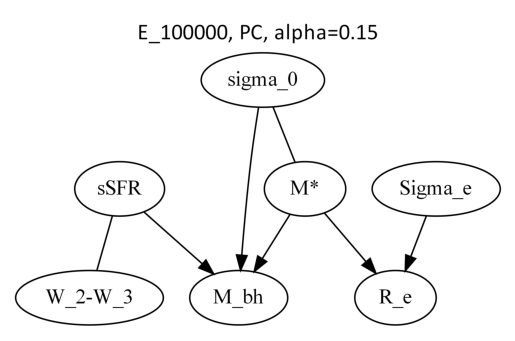

Depth=0, working on node 6: 100%|██████████| 7/7 [00:00<?, ?it/s]


X5 --> X2


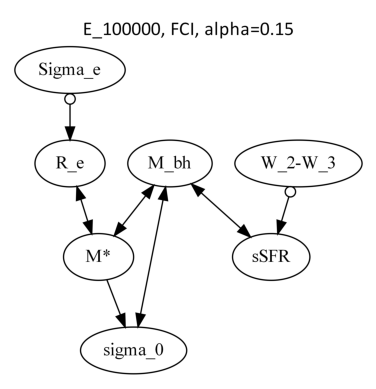

E_200000


FileNotFoundError: [Errno 2] No such file or directory: 'causal_BH_ell_200000.csv'

In [33]:
for galtype in galtypes:
    print(typename[galtype])
    print('===================================================')
    df = pd.read_csv('causal_BH_'+galtype+'.csv')
    plot_pc(df,alpha=0.15,name=typename[galtype])
    plot_fci(df,alpha=0.15,name=typename[galtype])
    print('===================================================')

In [48]:
def adj2DAG(adjacency_matrix):
    num_nodes = adjacency_matrix.shape[0]
    cg = CausalGraph(num_nodes)
    for i in range(num_nodes):
        for j in range(num_nodes):
            edge1 = cg.G.get_edge(cg.G.nodes[i], cg.G.nodes[j])
            if edge1 is not None:
                cg.G.remove_edge(edge1)

    for i in range(num_nodes):
        for j in range(num_nodes):
            if adjacency_matrix[i,j] == 1:
                cg.G.add_edge(Edge(cg.G.nodes[i], cg.G.nodes[j], Endpoint.TAIL, Endpoint.ARROW))

    return cg.G

def find_unique_MEC(MECs,MEC_objects):
    # find unique MECs, also get unique MEC objects according to the unique MECs
    unique_MECs, index, counts = np.unique(MECs, axis=0, return_counts=True, return_index=True)
    unique_MEC_objects = [MEC_objects[i] for i in index]
    sorted_indices = np.argsort(-counts)
    unique_MECs = unique_MECs[sorted_indices]
    counts = counts[sorted_indices]
    unique_MEC_objects = [unique_MEC_objects[i] for i in sorted_indices]
    
    print('unique MECs: ', unique_MECs.shape[0],'/',MECs.shape[0],'(',unique_MECs.shape[0]/MECs.shape[0]*100,'%)')

    return unique_MECs, counts, unique_MEC_objects


def plot_top_MECs(unique_MEC_objects, MEC_counts, num=10, save: str |None = None):
    labels_list_MEC = ['M_bh','sigma_0', 'R_e', 'Sigma_e','M*', 'sSFR', 'W_2-W_3']
    samplesize = MEC_counts.sum()

    for i in range(len(unique_MEC_objects[:num])):
        pyd=GraphUtils.to_pydot(unique_MEC_objects[i],labels=labels_list_MEC)

        pyd.set_label(str(MEC_counts[i])+'/'+str(samplesize)+' ('+format(MEC_counts[i]/samplesize*100,'.3g')+'%)')
        pyd.set_labelloc('t')
        pyd.set_fontsize(15)
        pyd.set_fontname('Calibri')
        pyd.set_dpi(600)

        tmp_png = pyd.create_png(f="png")
        fp = io.BytesIO(tmp_png)
        img = mpimg.imread(fp, format='png')
        plt.axis('off')
        plt.imshow(img)
        if save is not None:
            plt.imsave('MEC_'+save+'_top'+str(i+1)+'.png',img)
        plt.show()

In [33]:
MECs={}
unique_MECs={}
MEC_counts={}
MEC_shds={}
unique_MEC_objects={}
for galtype in galtypes:
    folder = 'output_'+galtype+'/'
    # should have been done in the previous cell
    #posterior[galtype] = np.load(folder+'posterior.npy')

    # Convert DAGs to MECs
    MECs[galtype] = np.zeros((posterior[galtype].shape[0], posterior[galtype].shape[1], posterior[galtype].shape[2]))
    MEC_objects = []
    for i,adj in enumerate(tqdm(posterior[galtype], total=posterior[galtype].shape[0])):
        # adjaceny matrix to DAG
        dag = adj2DAG(adj)
        # DAG to MEC/CPDAG
        cpdag = dag2cpdag(dag)
        # causallearn graph object
        MEC_objects.append(cpdag)
        # MEC graph as array
        MECs[galtype][i] = cpdag.graph

    # get unique MECs
    unique_MECs[galtype], MEC_counts[galtype], unique_MEC_objects[galtype] = find_unique_MEC(MECs[galtype],MEC_objects)

    # get shd
    MEC_shds[galtype] = np.zeros(len(unique_MEC_objects[galtype]))
    for i,mec in enumerate(unique_MEC_objects[galtype]):
        MEC_shds[galtype][i] = SHD(unique_MEC_objects[galtype][0], mec).get_shd()

    np.save('MECs/MECs.npy', MECs)
    np.save('MECs/unique_MECs.npy', unique_MECs)
    np.save('MECs/MEC_counts.npy', MEC_counts)
    np.save('MECs/MEC_shds.npy', MEC_shds)
    np.save('MECs/unique_MEC_objects.npy', unique_MEC_objects)

100%|██████████| 100000/100000 [03:26<00:00, 483.16it/s]


unique MECs:  31439 / 100000 ( 31.439 %)


100%|██████████| 100000/100000 [03:21<00:00, 497.35it/s]


unique MECs:  46073 / 100000 ( 46.073 %)


100%|██████████| 100000/100000 [03:57<00:00, 421.12it/s]


unique MECs:  49783 / 100000 ( 49.783 %)


In [42]:
MECs = np.load('MECs/MECs.npy',allow_pickle=True).item()
unique_MECs = np.load('MECs/unique_MECs.npy',allow_pickle=True).item()
MEC_counts = np.load('MECs/MEC_counts.npy',allow_pickle=True).item()
MEC_shds = np.load('MECs/MEC_shds.npy',allow_pickle=True).item()
unique_MEC_objects = np.load('MECs/unique_MEC_objects.npy',allow_pickle=True).item()

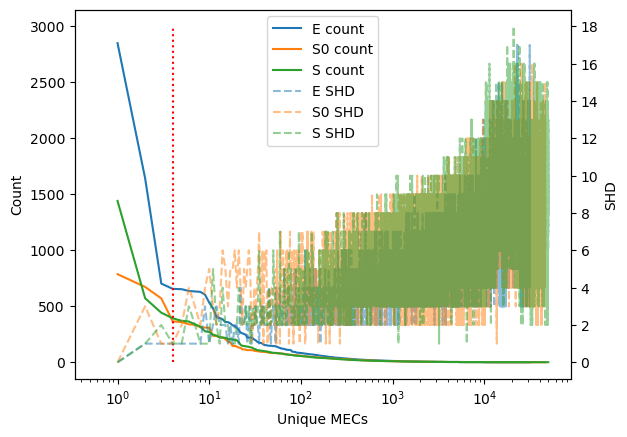

In [46]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()


for galtype in galtypes:
    # plot count of unique samples on using the left y axis, and the shd on the right y axis

    ax1.plot(np.arange(len(MEC_counts[galtype]))+1, MEC_counts[galtype],label=typename[galtype]+' count')
    ax2.plot(np.arange(len(MEC_counts[galtype]))+1, MEC_shds[galtype], alpha=0.5,ls='--',label=typename[galtype]+' SHD')

ax1.set_xlabel('Unique MECs')
ax1.set_ylabel('Count')
ax1.set_xscale('log')
ax2.set_ylabel('SHD')
ax2.set_yticks(np.arange(0, 20, 2))
ax1.vlines(4,0,3000,linestyles='dotted',colors='r')

# Combine the legends of ax1 and ax2
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2,loc='upper center')

E


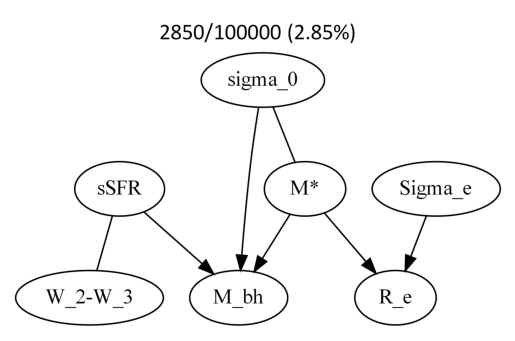

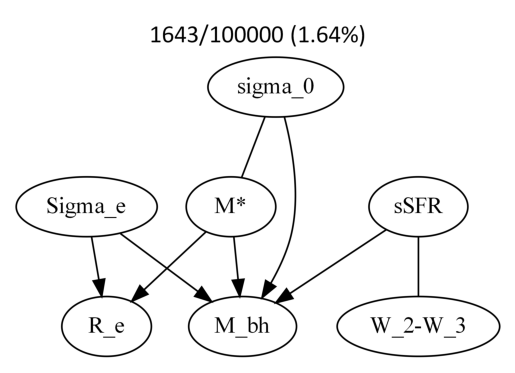

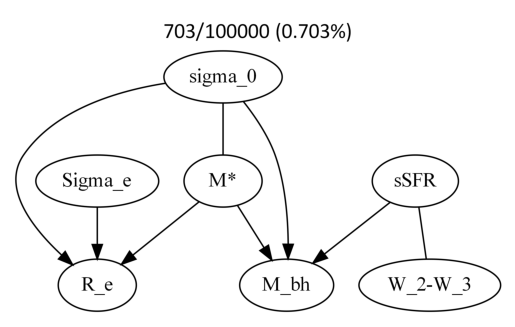

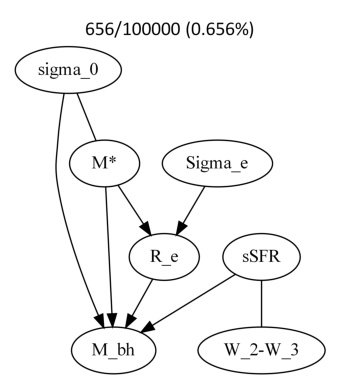

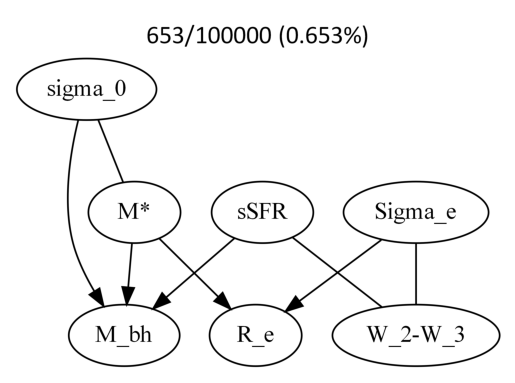

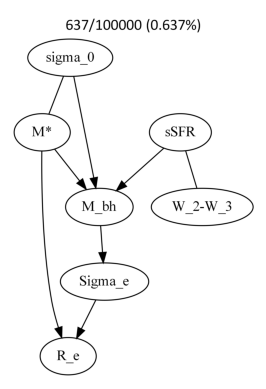

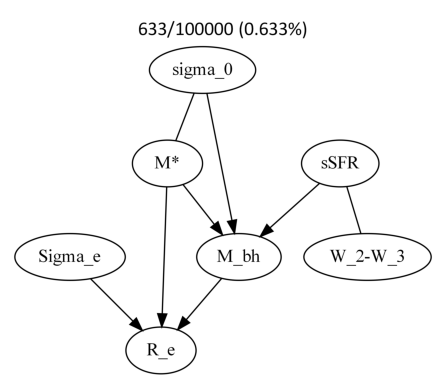

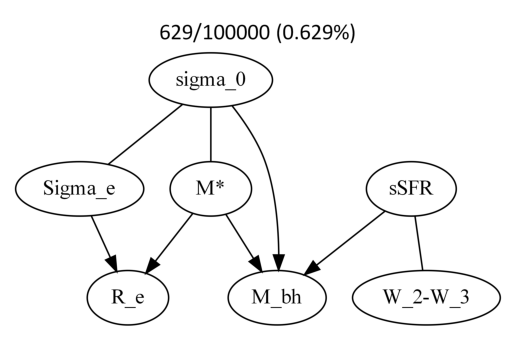

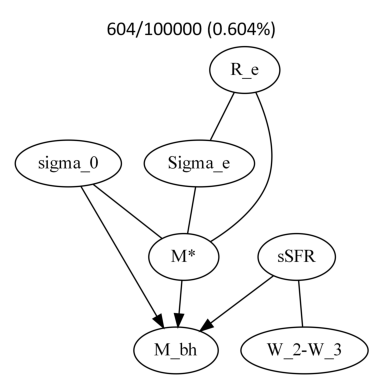

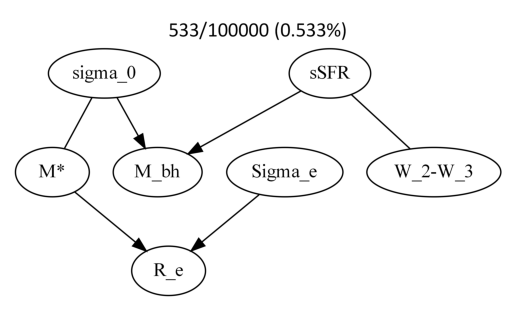

S0


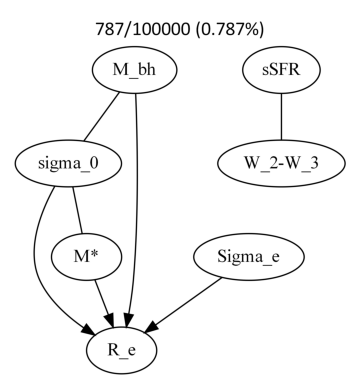

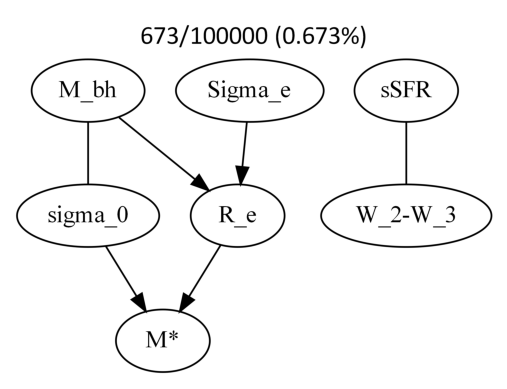

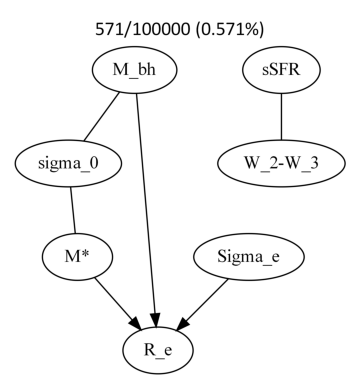

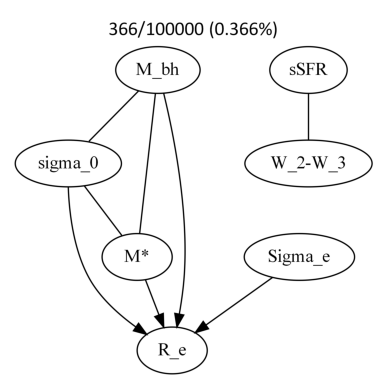

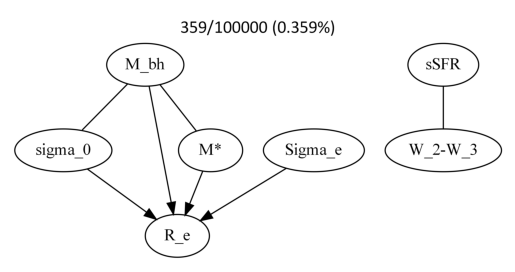

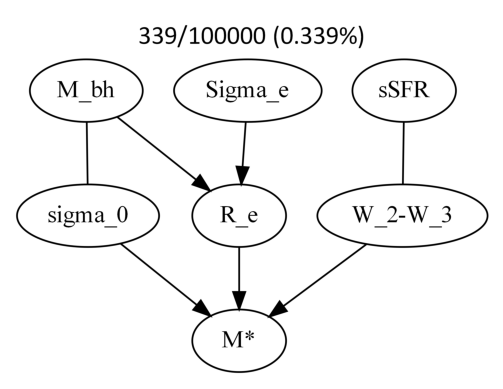

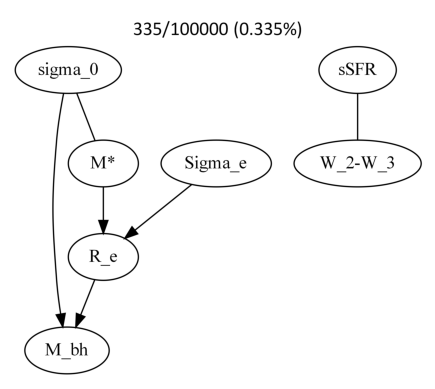

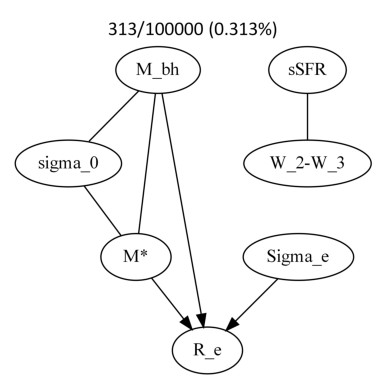

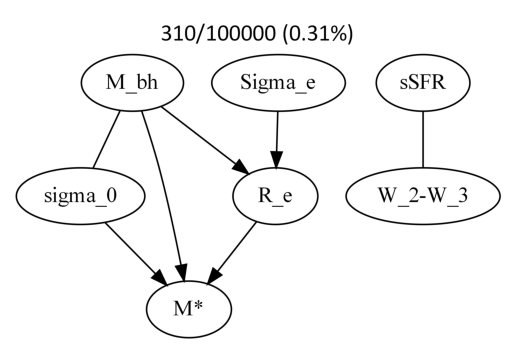

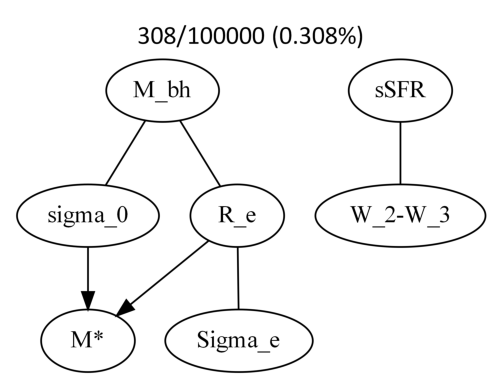

S


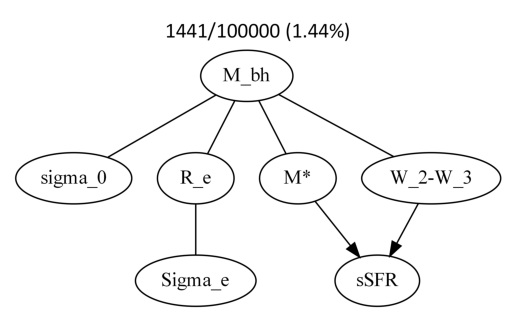

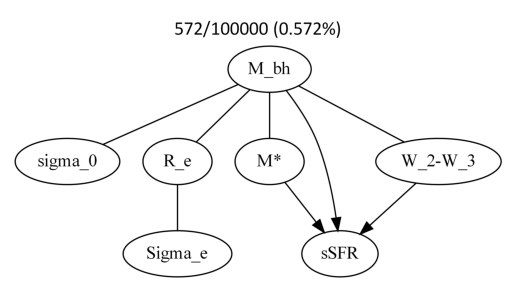

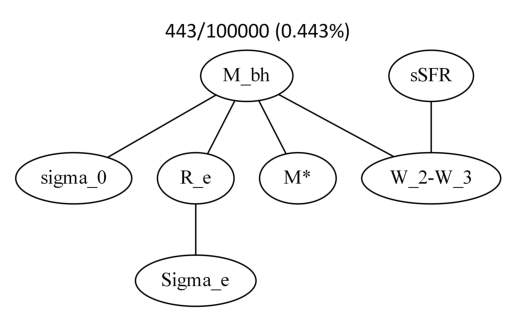

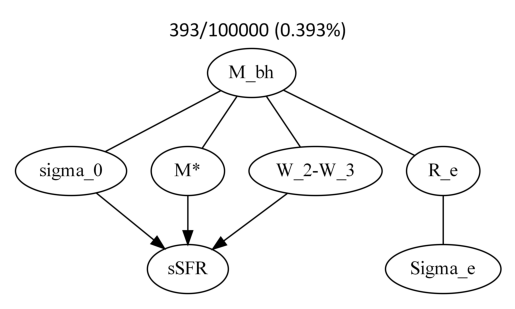

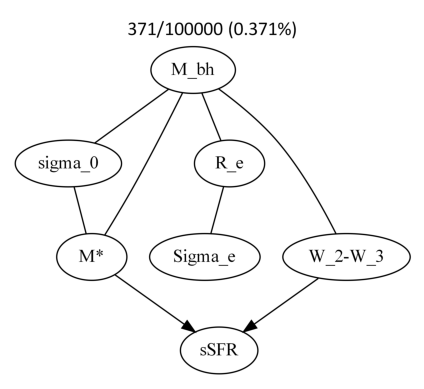

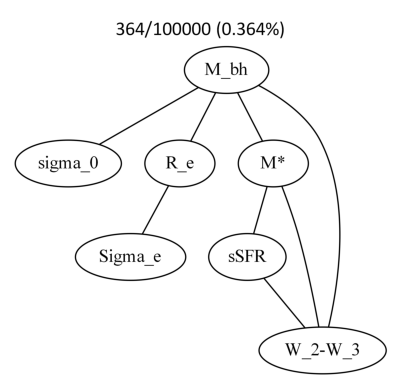

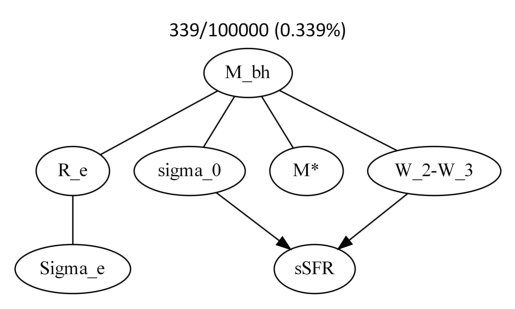

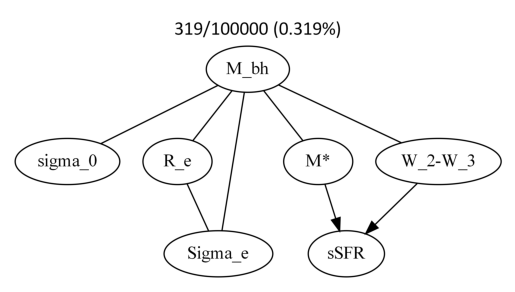

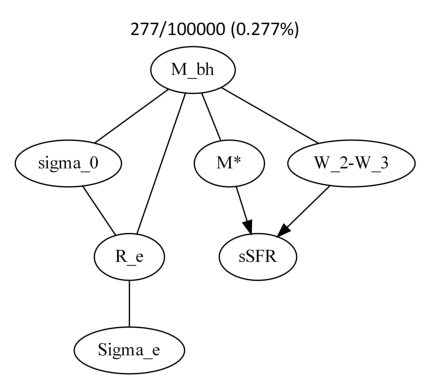

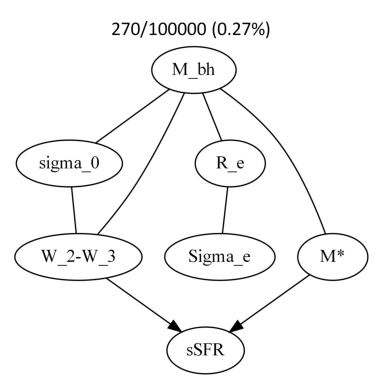

In [49]:
for galtype in galtypes:
    print(typename[galtype])
    print('===================================================')
    plot_top_MECs(unique_MEC_objects[galtype], MEC_counts[galtype], num=10, save=galtype)
    print('===================================================')

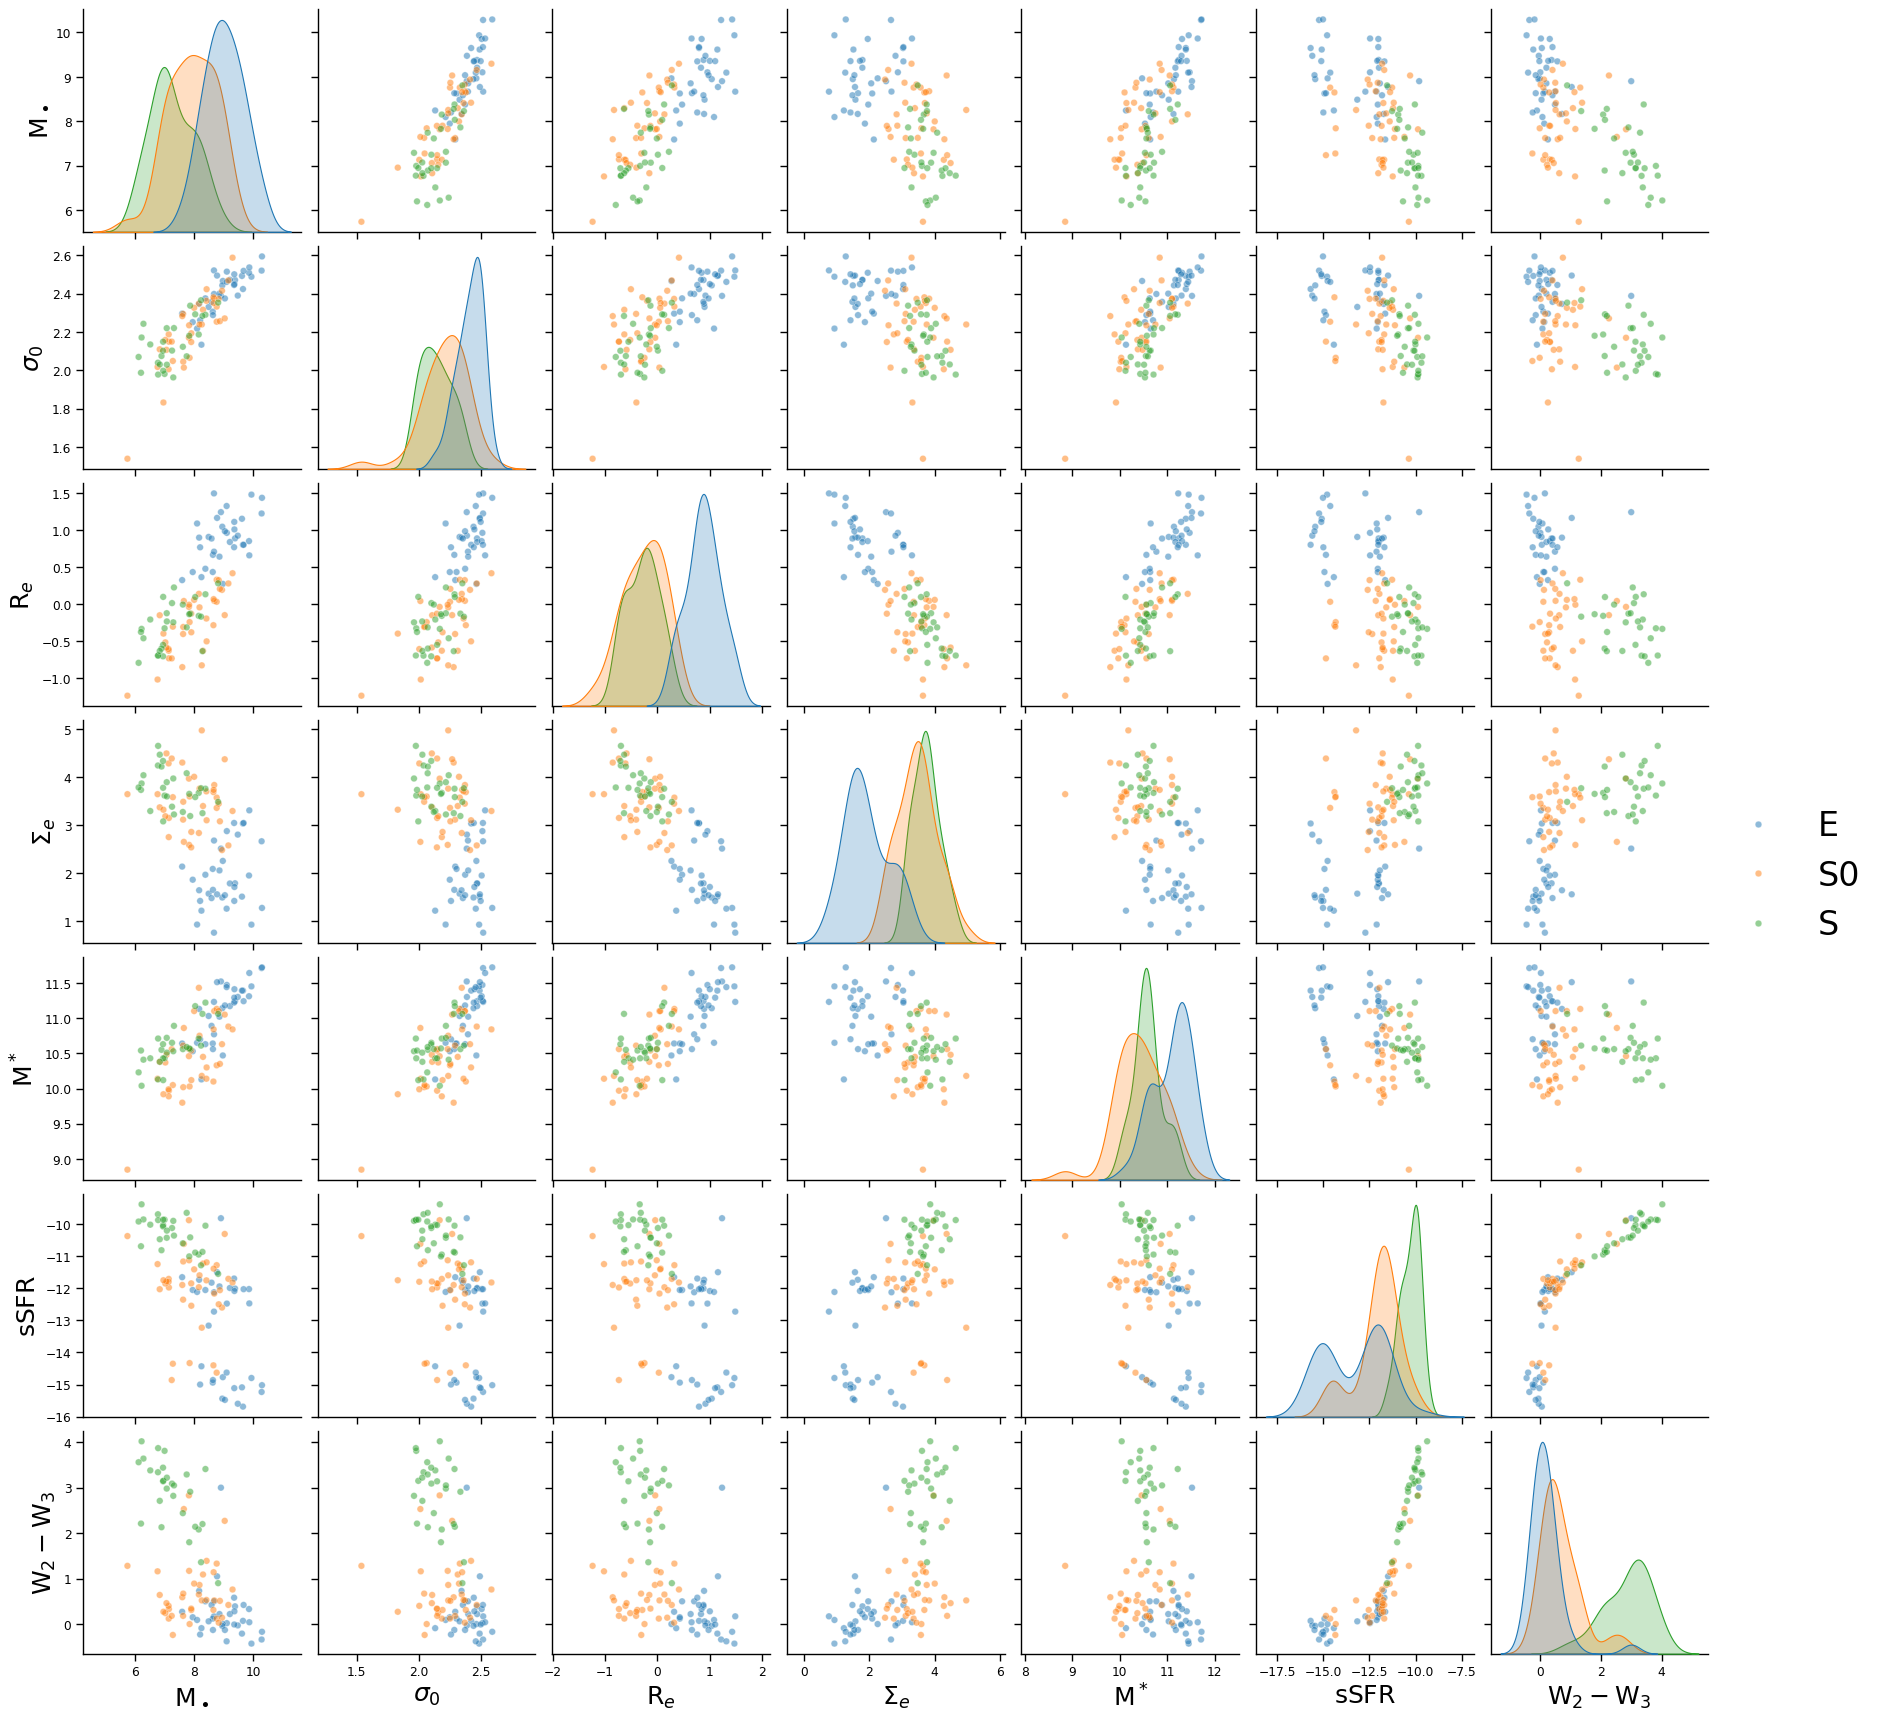

In [13]:
# plot the pairplot of each galtype data located at 'causal_BH_'+galtype+'.csv'on one pairplot, use different color for each galtype, and use labels_list for the labels
for galtype in galtypes:
    df = pd.read_csv('causal_BH_'+galtype+'.csv')
    df['galtype'] = typename[galtype]
    if galtype == 'ell':
        df_all = df
    else:
        df_all = pd.concat([df_all,df])
# rename column names to labels_list
df_all.columns = labels_list + [' ']
sns.set_context("paper", rc={"axes.labelsize":18,"legend.fontsize":24})
sns.pairplot(df_all, hue=' ', diag_kind='kde', plot_kws={'alpha':0.5})